In [1]:
import numpy as np
import random
import os, os.path
import cv2
import skimage
from skimage import io, draw
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.transform import rescale
from scipy.fftpack import dct
import imageio
from IPython.display import Image
from collections import Counter

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib import pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
def load_from_folders(path,k, from_idx=0, to_idx=100, seed=0):
    train = []
    train_labels = []
    test = []
    test_labels = []
    i = 0
    for_delete = set()
    random.seed(seed);
    for dir in os.listdir(path)[from_idx:to_idx]:
        dir_path = os.path.join(path, dir)
        if os.path.isdir(dir_path):
            subj_images = []
            if len(os.listdir(dir_path)) < 11:
                for_delete.add(dir_path[-3:])
            for file in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file)
                if file_path[-1] != 't':
                    img = io.imread(file_path)
                    if img.shape != (256,256):
                        for_delete.add(dir_path[-3:])
                    subj_images.append(img)
            if(seed >= 0):
                random.shuffle(subj_images)
            subj_images = subj_images[::-1]
            
            test.extend(subj_images[0:k])    # одно изображение для распознавания
            test_labels.extend([i for x in subj_images[:k]])    # метки класса
            train.extend(subj_images[k:])  # Другие разпознаем
            train_labels.extend([i for x in subj_images[k:]])    # метки класса
            i +=1
    train = np.array(train)
    test = np.array(test)
    return train, train_labels, test, test_labels

In [4]:
color = [100, 0, 0]  # 'cause purple!
top, bottom, left, right = [6]*4
train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', 3 ,0, 100)

In [5]:
def cosine_similarity(a,b):
    return np.dot(a.reshape(-1), b.reshape(-1))/(np.linalg.norm(a)*np.linalg.norm(b))

def distance(a,b,mode='euc'):
    if mode=='euc':
        return np.linalg.norm(a - b)
    elif mode=='abs':
        return np.mean(np.abs(a.reshape(-1) - b.reshape(-1)))

In [6]:
def classify(clf, img, train, train_labels, transform=True):
    if transform:
        distances = np.array(list(map(lambda img2: clf.Distance(img, img2), train)))
    else:
        distances = np.array(list(map(lambda img2: clf.Distance_simple(img, img2), train)))
    return train_labels[distances.argmin()]

In [7]:
class HistogramClassifier:
    def __init__(self, size=10):
        self.size = size
        
    def Distance(self, img1, img2):
        img1_hist = cv2.calcHist([np.float32(img1)],[0],None,[self.size],[0,256])
        img2_hist = cv2.calcHist([np.float32(img2)],[0],None,[self.size],[0,256])
        return np.linalg.norm(img1_hist - img2_hist)
    
    def Distance_simple(self, img1_hist, img2_hist):
        return np.linalg.norm(img1_hist - img2_hist)

In [8]:
class DFTClassifier:
    def __init__(self, size=100):
        self.size = size
        
    def Distance(self, img1, img2): 
        img1_dft = np.fft.fft2(img1)
        img1_dft = np.fft.fftshift(img1_dft)
        img1_dft = 20*np.log(np.abs(img1_dft))
        img1_dft = img1_dft[:self.size, :self.size]
        
        img2_dft = np.fft.fft2(img2)
        img2_dft = np.fft.fftshift(img2_dft)
        img2_dft = 20*np.log(np.abs(img2_dft))
        img2_dft = img2_dft[:self.size, :self.size]
        
        return np.linalg.norm(img1_dft - img2_dft)
    
    def Distance_simple(self, img1_dft, img2_dft):
        return np.linalg.norm(img1_dft - img2_dft)

In [9]:
class DCTClassifier:
    def __init__(self, size=10):
        self.size = size
        
    def Distance(self, img1, img2):
        img1_dct = dct(dct(img1.T, norm='ortho').T, norm='ortho')
        img1_dct = img1_dct[:self.size, :self.size]
        img2_dct = dct(dct(img2.T, norm='ortho').T, norm='ortho')
        img2_dct = img2_dct[:self.size, :self.size]
        return np.linalg.norm(img1_dct - img2_dct)
    
    def Distance_simple(self, img1_dct, img2_dct):
        return np.linalg.norm(img1_dct - img2_dct)

In [10]:
class ScaleClassifier:
    def __init__(self, scales=[2,3,4]):
        self.scales = scales

    def Distance(self, img1, img2):
        dist = 0
        
        for s in self.scales:
            img1_rescaled = rescale(img1, 1/s, mode='constant', anti_aliasing=False, multichannel=False)
            img2_rescaled = rescale(img2, 1/s, mode='constant', anti_aliasing=False, multichannel=False)
            
            dist += np.linalg.norm(img1_rescaled - img2_rescaled)
        
        dist /= len(self.scales)
        return dist
    
    def Distance_simple(self, img1_rescaled, img2_rescaled):
        return np.linalg.norm(img1_rescaled - img2_rescaled)

In [11]:
class GradientClassifier:
    def __init__(self, ksize=5, ord=0.05):
        self.ksize = ksize
        self.ord = ord
    
    def Distance(self, img1, img2):
        img1_grad = cv2.Sobel(img1,cv2.CV_64F,0,1,ksize=self.ksize).mean(axis=0)
        img2_grad = cv2.Sobel(img2,cv2.CV_64F,0,1,ksize=self.ksize).mean(axis=0)
        return np.linalg.norm(img1_grad - img2_grad, ord=self.ord)
    
    def Distance_simple(self, img1_grad, img2_grad):
        return np.linalg.norm(img1_grad - img2_grad)

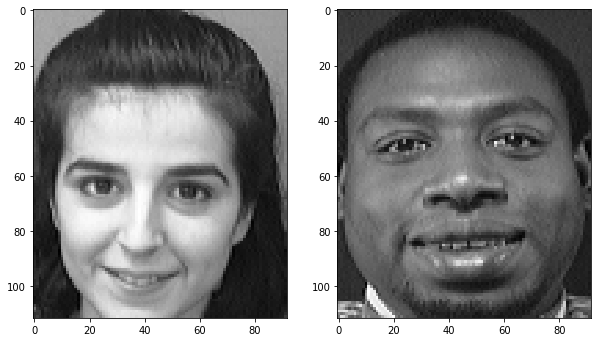

In [13]:

s = ""
image1 = io.imread(s+"data/orl_faces/s10/1.pgm")
image2 = io.imread(s+"data/orl_faces/s22/1.pgm")

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2, 1)
plt.imshow(image1, cmap="gray")
fig.add_subplot(1,2, 2)
plt.imshow(image2, cmap="gray")

4.1231055 4.1231055


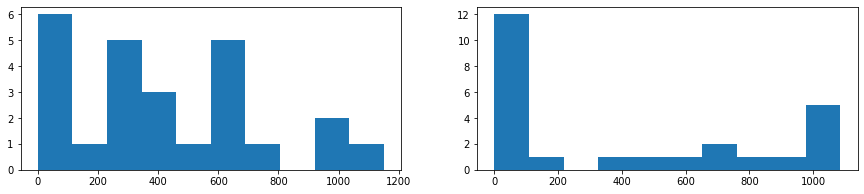

In [14]:
# Гистограмма яркости
size = 25
hist_clf = HistogramClassifier(size)

img1_hist = cv2.calcHist([image1],[0],None,[size],[0,256])
img2_hist = cv2.calcHist([image2],[0],None,[size],[0,256])

fig = plt.figure(figsize=(15,3))
fig.add_subplot(1,2, 1)
plt.hist(img1_hist)
fig.add_subplot(1,2, 2)
plt.hist(img2_hist)
print(hist_clf.Distance(img1_hist,img2_hist), hist_clf.Distance(img1_hist,img2_hist))

182.96453465858175 182.96453465858175


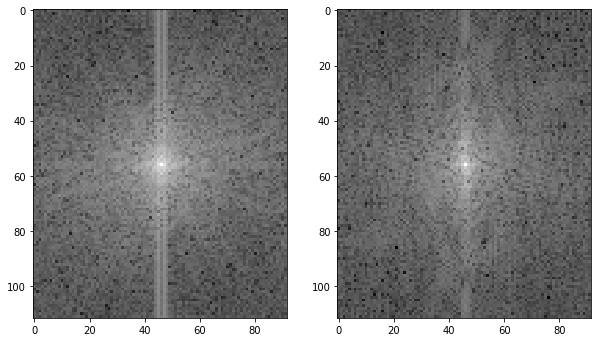

In [15]:
# DFT
size=10
dft_clf = DFTClassifier(size=size)

img1_dft = np.fft.fft2(image1)
img1_dft = np.fft.fftshift(img1_dft)
img1_dft = 20*np.log(np.abs(img1_dft))

img2_dft = np.fft.fft2(image2)
img2_dft = np.fft.fftshift(img2_dft)
img2_dft = 20*np.log(np.abs(img2_dft))

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2, 1)
plt.imshow(img1_dft, cmap="gray")
fig.add_subplot(1,2, 2)
plt.imshow(img2_dft, cmap="gray")

print(dft_clf.Distance(image1,image2), dft_clf.Distance(image1,image2))

3926.938528891909 3926.938528891909


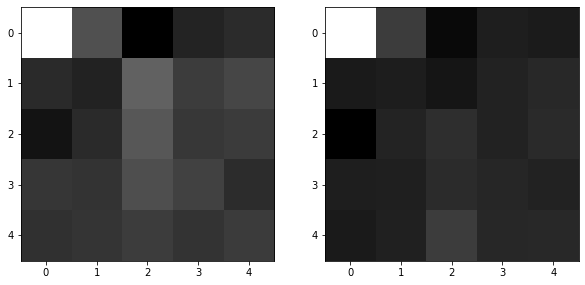

In [16]:
# DCT
size = 5
dct_clf = DCTClassifier(size=5)

img1_dct = dct(dct(image1.T, norm='ortho').T, norm='ortho')
img1_dct = img1_dct[:size, :size]
img2_dct = dct(dct(image2.T, norm='ortho').T, norm='ortho')
img2_dct = img2_dct[:size, :size]

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2, 1)
plt.imshow(img1_dct, cmap="gray")
fig.add_subplot(1,2, 2)
plt.imshow(img2_dct, cmap="gray")

print(dct_clf.Distance(image1,image2), dct_clf.Distance(image1,image2))

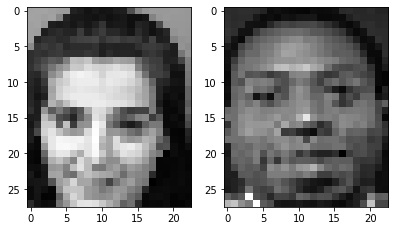

5.811751888663062 5.811751888663062


In [17]:
# Scale
coeff = 4
scale_clf = ScaleClassifier(scales=[coeff])

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3, 1)
plt.imshow(rescale(image1, 1/float(coeff), mode='constant', anti_aliasing=False, multichannel=False), cmap="gray")
fig.add_subplot(1,3, 2)
plt.imshow(rescale(image2, 1/float(coeff), mode='constant', anti_aliasing=False, multichannel=False), cmap="gray")
plt.show()

print(scale_clf.Distance(image1,image2), scale_clf.Distance(image1,image2))

8.96285589836414e+56


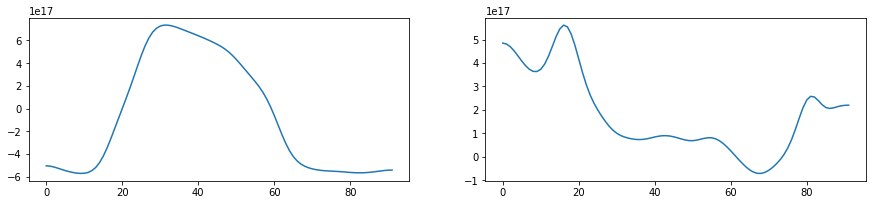

In [18]:
# Градиент
ksize = 31

grad_clf = GradientClassifier(ksize=ksize)

img1_grad = cv2.Sobel(image1,cv2.CV_64F,0,1,ksize=ksize).mean(axis=0)
img2_grad = cv2.Sobel(image2,cv2.CV_64F,0,1,ksize=ksize).mean(axis=0)

fig = plt.figure(figsize=(15,3))
fig.add_subplot(1,2, 1)
plt.plot(img1_grad)
fig.add_subplot(1,2, 2)
plt.plot(img2_grad)

print(grad_clf.Distance(image1,image2))

In [22]:
train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', 8 ,0, 100)

hist_clf = HistogramClassifier(size=10)
dft_clf = DFTClassifier(size=66)
dct_clf = DCTClassifier(size=4)
scale_clf = ScaleClassifier(scales=[4])
grad_clf = GradientClassifier(ksize=13)


hist=0
dft=0
dctt=0
scale=0
grad=0


for i, img in enumerate(train):
    label = train_labels[i]
    
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(2,3, 1)
    
    pred = classify(hist_clf, train[i], test, test_labels)
    if label==pred:
        plt.imshow(img, cmap="gray")
        hist += 1
    else:
        image1 = cv2.copyMakeBorder(test[test_labels.index(pred)], top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        plt.imshow(image1, cmap="hot")
    plt.title("Гистограмма яркости")
    
    fig.add_subplot(2,3, 2)
    pred = classify(dft_clf, train[i], test, test_labels)
    if label==pred:
        plt.imshow(img, cmap="gray")
        dft += 1
    else:
        image1 = cv2.copyMakeBorder(test[test_labels.index(pred)], top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        plt.imshow(image1, cmap="hot")
    plt.title("DFT")
    
    fig.add_subplot(2,3, 3)
    
    pred=classify(dct_clf, train[i], test, test_labels)
    if label==pred:
        plt.imshow(img, cmap="gray")
        dctt += 1
    else:
        image1 = cv2.copyMakeBorder(test[test_labels.index(pred)], top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        plt.imshow(image1, cmap="hot")
    plt.title("DCT")
       
    fig.add_subplot(2,3, 4)
    
    pred=classify(scale_clf, train[i], test, test_labels)
    if label==pred:
        scale += 1
        plt.imshow(img, cmap="gray")
    else:
        image1 = cv2.copyMakeBorder(test[test_labels.index(pred)], top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        plt.imshow(image1, cmap="hot")
    plt.title("Scale")
    

    fig.add_subplot(2,3, 5)
    pred=classify(grad_clf, train[i], test, test_labels)
    if label==pred:
        plt.imshow(img, cmap="gray")
        grad += 1
    else:
        image1 = cv2.copyMakeBorder(test[test_labels.index(pred)], top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        plt.imshow(image1, cmap="hot")
    plt.title("Градиент ")
    
    
    fig.add_subplot(2,3, 6)
        
    plt.imshow(test[test_labels.index(label)], cmap="gray")
    plt.title("Real")
    
    fig.savefig('data/temp/' + str(i) + '.png')
    fig.clear()
    plt.show()
    
    
print(hist/ len(train))
print(dft/ len(train))
print(dctt/ len(train))
print(scale/ len(train))
print(grad/ len(train))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

0.975
0.9375
0.9875
0.9625
0.8625


In [23]:
images = []
filenames = []
for i in range(len(train)):
    filenames.append("data/temp/{}.png".format(i))
for filename in filenames:
    images.append(imageio.imread(filename))
    
imageio.mimsave('results.gif', images, duration=0.2)

Image(url='results.gif')  

In [24]:
class_images = 10
hist_clf = HistogramClassifier(size=15)
dft_clf = DFTClassifier(size=60)
dct_clf = DCTClassifier(size=4)
scale_clf = ScaleClassifier(scales=[4])
grad_clf = GradientClassifier(ksize=13)

[0.5847953216374269, 0.7532894736842105, 0.8157894736842105, 0.8508771929824561, 0.9105263157894737, 0.9407894736842105, 0.9824561403508771, 0.9736842105263158, 0.9736842105263158]


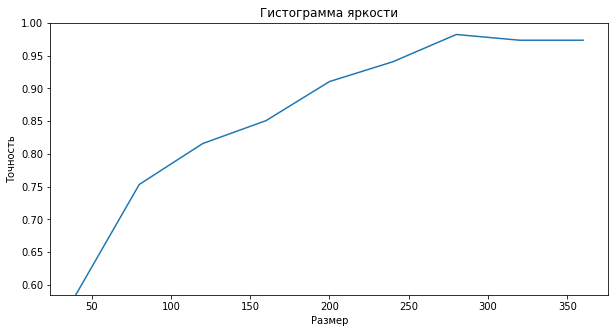

In [26]:
history = []
for i in range(1,class_images):
    train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', i ,0, 40, 2)
    
    acc =0
    for i, img in enumerate(train):
        label = train_labels[i]

        if label==classify(hist_clf, train[i], test, test_labels):
            acc += 1
    acc = float(acc) / len(train)
    history.append(acc)
    
print(history)

x_points = [i*40 for i in range(1,class_images)]
fig = plt.figure(figsize=(10,5))
plt.plot(x_points, history)
plt.title("Гистограмма яркости")
plt.xlabel("Размер")
plt.ylabel('Точность')
plt.ylim((min(history),1))

plt.show()

[0.4327485380116959, 0.625, 0.7142857142857143, 0.8026315789473685, 0.8526315789473684, 0.8881578947368421, 0.9210526315789473, 0.9605263157894737]


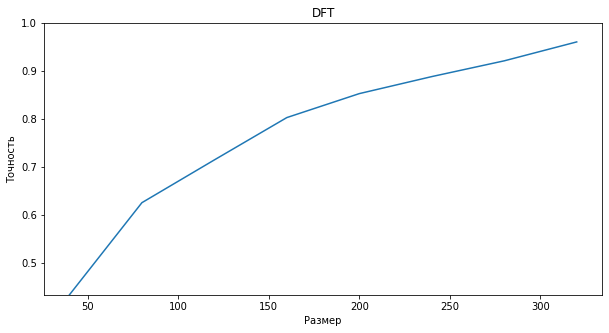

In [27]:
class_images = 9

history = []
for i in range(1,class_images):
    train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', i ,0, 40)
    
    acc =0
    for i, img in enumerate(train):
        label = train_labels[i]

        if label==classify(dft_clf, train[i], test, test_labels):
            acc += 1
    acc = float(acc) / len(train)
    history.append(acc)
    
print(history)

x_points = [i*40 for i in range(1,class_images)]
fig = plt.figure(figsize=(10,5))
plt.plot(x_points, history)
plt.title("DFT")
plt.xlabel("Размер")
plt.ylabel('Точность')
plt.ylim((0,1))
plt.ylim((min(history),1))

plt.show()

[0.6257309941520468, 0.7697368421052632, 0.7857142857142857, 0.8947368421052632, 0.9526315789473684, 0.9605263157894737, 0.9736842105263158, 0.9868421052631579]


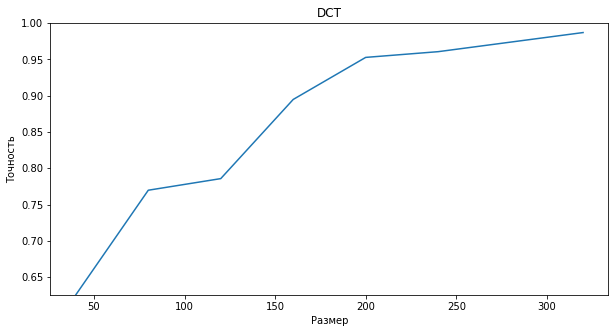

In [28]:
class_images = 9
history = []
for i in range(1,class_images):
    train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', i ,0, 40)
    
    acc =0
    for i, img in enumerate(train):
        label = train_labels[i]

        if label==classify(dct_clf, train[i], test, test_labels):
            acc += 1
    acc = float(acc) / len(train)
    history.append(acc)
    
print(history)

x_points = [i*40 for i in range(1,class_images)]
fig = plt.figure(figsize=(10,5))
plt.plot(x_points, history)
plt.title("DCT")
plt.xlabel("Размер")
plt.ylabel('Точность')
plt.ylim((0,1))
plt.ylim((min(history),1))

plt.show()

[0.6842105263157895, 0.8256578947368421, 0.8796992481203008, 0.9429824561403509, 0.9473684210526315, 0.9605263157894737, 0.9736842105263158, 0.9605263157894737]


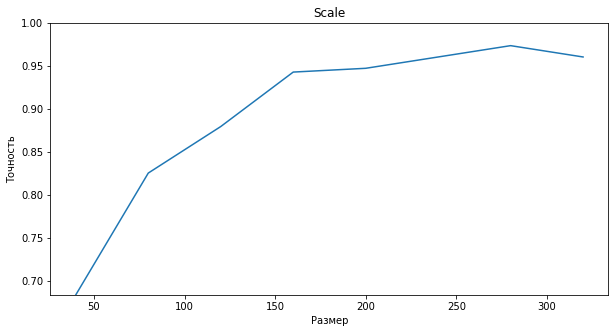

In [29]:
class_images = 9

history = []
for i in range(1,class_images):
    train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', i ,0, 40)
    
    acc =0
    for i, img in enumerate(train):
        label = train_labels[i]

        if label==classify(scale_clf, train[i], test, test_labels):
            acc += 1
    acc = float(acc) / len(train)
    history.append(acc)
    
print(history)

x_points = [i*40 for i in range(1,class_images)]
fig = plt.figure(figsize=(10,5))
plt.plot(x_points, history)
plt.title("Scale")
plt.xlabel("Размер")
plt.ylabel('Точность')

plt.ylim((0,1))
plt.ylim((min(history),1))
plt.show()

[0.5292397660818714, 0.6052631578947368, 0.6766917293233082, 0.7368421052631579, 0.8210526315789474, 0.8289473684210527, 0.8157894736842105, 0.8552631578947368]


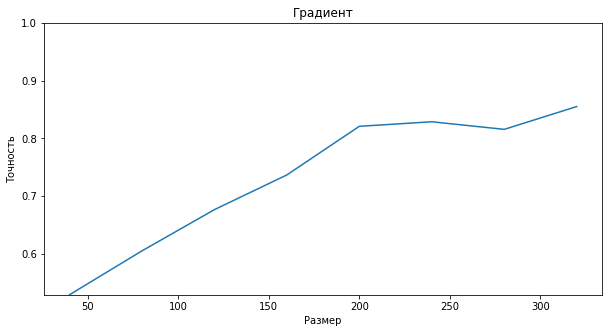

In [30]:
class_images = 9

history = []
for i in range(1,class_images):
    train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', i ,0, 40)
    
    acc =0
    for i, img in enumerate(train):
        label = train_labels[i]

        if label==classify(grad_clf, train[i], test, test_labels):
            acc += 1
    acc = float(acc) / len(train)
    history.append(acc)
    
print(history)

x_points = [i * 40 for i in range(1,class_images)]
fig = plt.figure(figsize=(10,5))
plt.plot(x_points, history)
plt.title("Градиент")
plt.xlabel("Размер")
plt.ylabel('Точность')
plt.ylim((0,1))
plt.ylim((min(history),1))

plt.show()

In [31]:

clfs = [scale_clf, dct_clf, dft_clf, hist_clf, grad_clf]

def classify_vote(clfs, img, train, train_labels):
    
    votes = []
    for clf in clfs:
        distances = np.array(list(map(lambda img2: clf.Distance(img, img2), train)))
        votes.append(train_labels[distances.argmin()])
    
    count = Counter(votes)
    return count.most_common()[0][0]


[0.7166666666666667, 0.840625, 0.9, 0.9708333333333333, 0.98, 0.99375, 1.0, 0.9875]


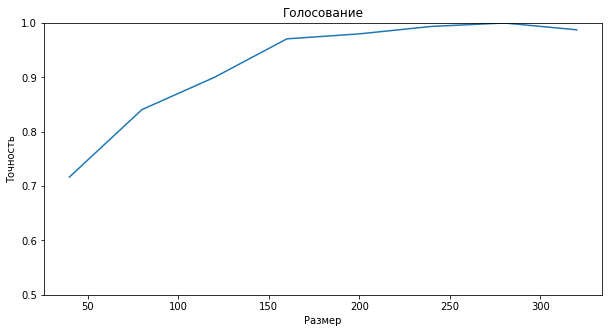

In [32]:
class_images = 9

history = []
for i in range(1,class_images):
    train, train_labels, test, test_labels = load_from_folders('data/orl_faces/', i ,0, 100)
    
    acc =0
    for i, img in enumerate(train):
        label = train_labels[i]

        if label==classify_vote(clfs, train[i], test, test_labels):
            acc += 1
    acc = float(acc) / len(train)
    history.append(acc)
    
print(history)

x_points = [i * 40 for i in range(1,class_images)]
fig = plt.figure(figsize=(10,5))
plt.plot(x_points, history)
plt.title("Голосование")
plt.xlabel("Размер")
plt.ylabel('Точность')
plt.ylim((0,1))
plt.ylim((0.5,1))

plt.show()

In [42]:
from func.upload_data import *
from func.classyfiers import *
import numpy as np
import warnings

40
Parallel system accuracy: 0.7583333333333334
80
Parallel system accuracy: 0.84375
120
Parallel system accuracy: 0.8464285714285715
160
Parallel system accuracy: 0.8583333333333334
200
Parallel system accuracy: 0.8850000000000001
240
Parallel system accuracy: 0.93125
280
Parallel system accuracy: 0.9416666666666668
320
Parallel system accuracy: 0.95
360
Parallel system accuracy: 0.95


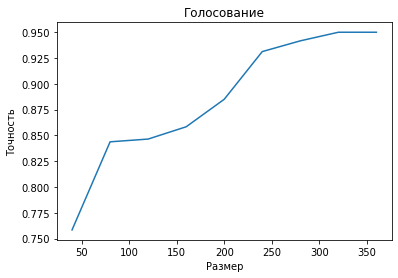

In [41]:
set=40

datasets, labels, train = facedataset(set)

X_mean = np.array(train).mean(axis=0)
X_std = np.array(train).std(axis=0)
train_norm = (train - X_mean)/X_std
datasets_norm = (datasets - X_mean)/X_std

trainnew = []
trainnew_n=[]
trainnew_n.append(train_norm)
trainnew.append(train)
X=[]
Parallel=[]

for i in range(9):
    #print('i', i+1)
    if i!=0:
        traintmp =[]
        datasets_norm_tmp =[]
        for l in range(len(datasets_norm)):
            traintmp.append(datasets_norm[l][0])
            datasets_norm_tmp.append(np.delete(datasets_norm[l],0,0))
        datasets_norm = np.array(datasets_norm_tmp)
    #print(datasets_norm.shape)
        trainnew_n.append(traintmp)

        print(len(trainnew_n[0])*len(trainnew_n))
        X.append(len(trainnew_n[0])*len(trainnew_n))

        traintmp = []

        for l in range(len(datasets)):
            traintmp.append(datasets[l][0])
            datasets[l].pop(0)

        trainnew.append(traintmp)
    else:
        print(set)
        X.append(40)
    
    label = 0
    loss = 1
    l_all =0
    # print('All')
    for dataset in datasets:
        loss=0
        for img in dataset:
            all_dist_Par = []
            
            for train in trainnew:
            
                dist = [Scale_clsf(img, img_c) for img_c in train]
                dist = dist / np.sum(dist)
                all_dist_Par.append(dist.argmin())

                dist = [RP_clsf(img, img_c) for img_c in train]
                dist = dist / np.sum(dist)
                all_dist_Par.append(dist.argmin())

                dist = [H_clsf(img, img_c) for img_c in train]
                dist = dist / np.sum(dist)
                all_dist_Par.append(dist.argmin())

                dist = [G_clsf(img, img_c) for img_c in train]
                dist = dist / np.sum(dist)
                all_dist_Par.append(dist.argmin())

                dist = [DCT_clsf(img, img_c) for img_c in train]
                dist = dist / np.sum(dist)
                all_dist_Par.append(dist.argmin())

                dist = [DFT_clsf(img, img_c) for img_c in train]
                dist = dist / np.sum(dist)
                all_dist_Par.append(dist.argmin())

            tmp_labels = np.array([all_dist_Par.count(g) for g in all_dist_Par])
            loss = loss +1 if all_dist_Par[tmp_labels.argmax()]==label else loss

        l_all += loss / len(dataset)
        label += 1
    print('Parallel system accuracy:', l_all / len(datasets))
    Parallel.append(l_all / len(datasets_norm))

plt.plot(X, Parallel)
plt.title("Голосование")
plt.xlabel('Размер')
plt.ylabel('Точность')
plt.show()